In [1]:
import numpy as np
import matplotlib.pyplot as plt
import networkx as nx
import pandas as pd

from sklearn import model_selection
from sklearn.naive_bayes import GaussianNB
from sklearn import preprocessing 
from sklearn.datasets import make_blobs
from sklearn.ensemble import RandomForestClassifier
from sklearn.calibration import CalibratedClassifierCV
from sklearn.metrics import pairwise_distances, log_loss
from sklearn.manifold import MDS
from mpl_toolkits.mplot3d import Axes3D

In [2]:
import sklearn_tda as sktda
# Can be downloaded at https://github.com/MathieuCarriere/sklearn-tda
import statmapper as stm
# Can be downloaded at https://github.com/MathieuCarriere/statmapper
from metricmapper import *

# Annulus

## Dataset

### Underlying manifold

In [3]:
num_pts = 5000
radius  = 1.

In [4]:
theta   = np.random.uniform(low=0., high=2*np.pi, size=num_pts)
xs, ys  = radius * np.cos(theta), radius * np.sin(theta)
noise_x = np.random.normal(loc=xs, scale=.1, size=num_pts)
noise_y = np.random.normal(loc=ys, scale=.1, size=num_pts)
X       = np.hstack([np.reshape(xs+noise_x, [-1,1]), np.reshape(ys+noise_y, [-1,1])])

<IPython.core.display.Javascript object>


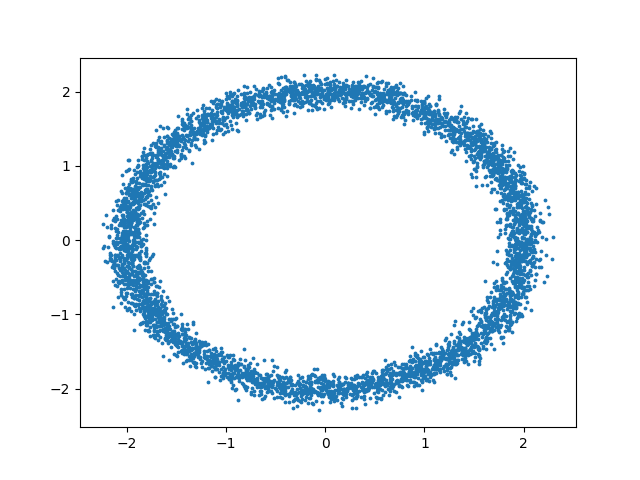

In [5]:
%matplotlib notebook
plt.scatter(X[:,0], X[:,1], s=3)
plt.show()

In [6]:
delta = sktda.estimate_scale(X, 100)
print(delta)

0.19043632568921084


### Probability distributions

#### Conditional distributions

In [ ]:
distributions = []

In [ ]:
num_samples = 10000

Gaussian distribution.

In [ ]:
for i in range(num_pts):
    distributions.append(np.random.normal(loc=X[i,0], scale=0.5, size=num_samples))

Bimodal distribution.

In [ ]:
for i in range(num_pts):
    distrib = []
    d1 = np.random.normal(loc=X[i,0]+2,  scale=0.1, size=num_samples)
    d2 = np.random.normal(loc=-X[i,0]-2, scale=0.1, size=num_samples)
    distrib = np.concatenate([d1[:int(num_samples/2)], d2[:int(num_samples/2)]])
    np.random.shuffle(distrib)
    distributions.append(distrib)

Visualization.

In [ ]:
%matplotlib notebook
plt.figure()
plt.hist(np.array(distributions[0]), bins=300, range=[-4.3,4.3])
plt.show()

In [ ]:
z = [distributions[i][0] for i in range(num_pts)]
z = [np.mean(distrib) for distrib in distributions]

In [ ]:
%matplotlib notebook
fig = plt.figure()
ax  = fig.add_subplot(111, projection="3d")
ax.scatter(X[:,0], X[:,1], z, s=1.)
ax.view_init(elev=33, azim=64)
plt.show()

#### Single observations

Gaussian distributions.

In [ ]:
real = []
for i in range(num_pts):
    real.append(np.random.normal(loc=X[i,0], scale=0.5, size=1)[0])

Bimodal distributions.

In [7]:
real = []
for i in range(num_pts):
    idx = np.random.choice(2, 1)
    if idx == 0:
        real.append(np.random.normal(loc=X[i,0]+2, scale=0.1, size=1)[0])
    else:
        real.append(np.random.normal(loc=-X[i,0]-2, scale=0.1, size=1)[0])

Visualization.

<IPython.core.display.Javascript object>


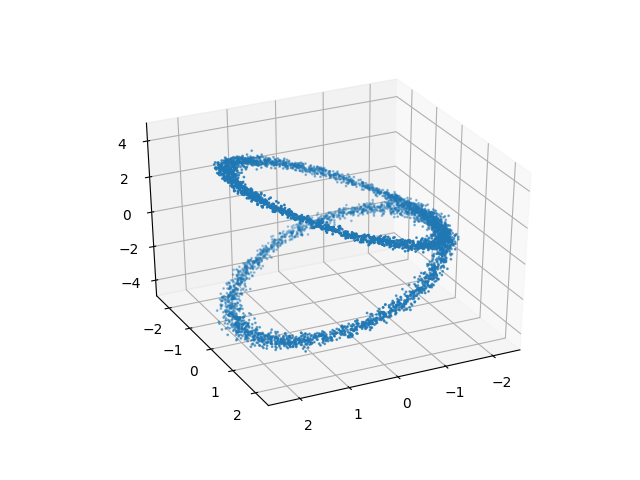

In [8]:
%matplotlib notebook
fig = plt.figure()
ax  = fig.add_subplot(111, projection="3d")
ax.scatter(X[:,0], X[:,1], real, s=1.)
ax.view_init(elev=33, azim=64)
plt.show()

#### Graphs

In [ ]:
real = []

In [ ]:
M, m = max(X[:,0]), min(X[:,0])
for i in range(num_pts):
    A = np.random.binomial(1, (X[i,0]-m)/(M-m), size=(5,5))
    Aplus, Aminus = np.triu(A), np.triu(A,1).T
    real.append(nx.Graph(Aplus + Aminus))

In [ ]:
nx.draw_networkx(real[60], with_labels=False)

## Single realization Mapper

In [9]:
mapper = sktda.MapperComplex(
    filters=np.reshape(real, [-1,1]), filter_bnds=np.array([[np.nan, np.nan]]),
    resolutions=np.array([15]), gains=np.array([.3]), colors=X[:,0:1],
    clustering=AgglomerativeClustering(n_clusters=None, linkage="single", distance_threshold=1.)
                            ).fit(X)

<IPython.core.display.Javascript object>


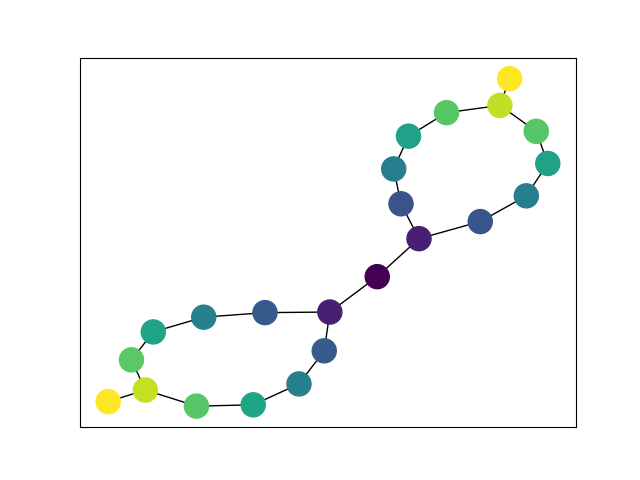

In [10]:
G = stm.mapper2networkx(mapper)
nx.draw_networkx(G, with_labels=False,
                 node_color=[mapper.node_info_[name]["colors"][0] for name in G.nodes()])

## Mean-based Mapper 

In [11]:
distributions = infer_distributions_from_neighborhood(real, X, 3*delta, "point cloud")
means = np.array([np.mean(distrib) for distrib in distributions])[:,np.newaxis]

In [12]:
mapper = sktda.MapperComplex(
    filters=means, filter_bnds=np.array([[np.nan, np.nan]]), 
    resolutions=np.array([10]), gains=np.array([.3]), colors=X[:,0:1],
    clustering=AgglomerativeClustering(n_clusters=None, linkage="single", distance_threshold=delta)
                            ).fit(X)

<IPython.core.display.Javascript object>


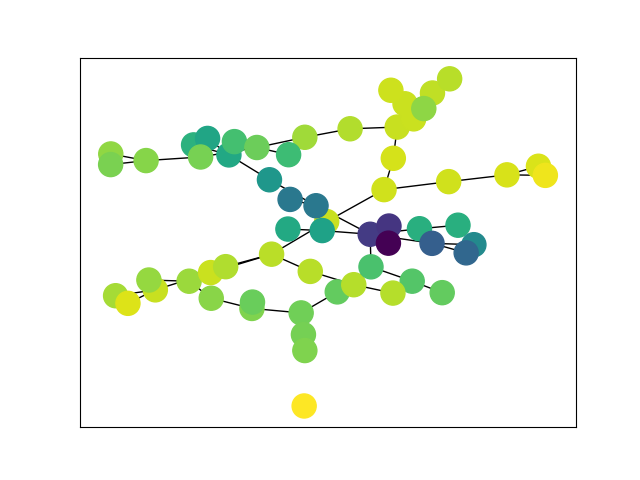

In [13]:
G = stm.mapper2networkx(mapper)
nx.draw_networkx(G, with_labels=False,
                 node_color=[mapper.node_info_[name]["colors"][0] for name in G.nodes()])

## Histogram-based Mapper

In [16]:
mapper = MetricMapperComplex(
    filters=real, codomain="distributions", infer_distributions=True, threshold=1., num_bins=100, 
    mode="NW", kernel=GaussianKernel(h=0.1),
    cover=kPDTMCover(num_patches=10, h=3, threshold=delta/10, tol=1e-7),
    correct_Rips=False, delta=delta, num_subdivisions=10,
    colors=np.reshape(X[:,0], [-1,1]), mask=5,
    clustering=AgglomerativeClustering(n_clusters=None, linkage="single", distance_threshold=delta)
                            ).fit(X)

<IPython.core.display.Javascript object>


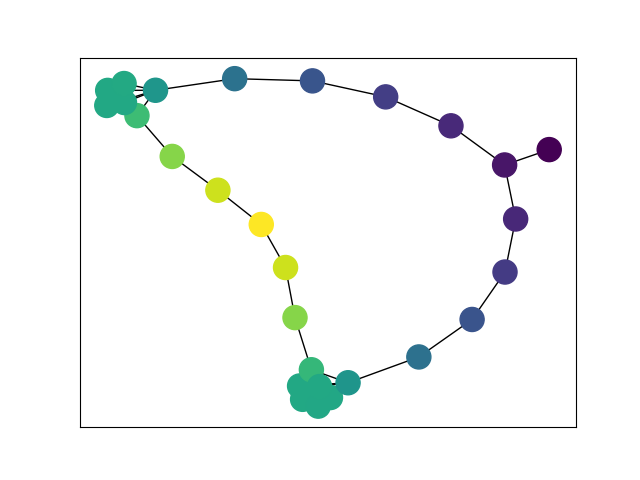

In [17]:
G = stm.mapper2networkx(mapper)
nx.draw_networkx(G, with_labels=False,
                 node_color=[mapper.node_info_[name]["colors"][0] for name in G.nodes()])

## Metric Mapper

Distances for conditional probability distributions.

In [18]:
distributions = infer_distributions_from_neighborhood(real, X, 3*delta, "point cloud")
H, _ = Histogram(num_bins=100).fit_transform(distributions)
dists = EuclideanDistance().compute_matrix(H)

Distances for combinatorial graphs.

In [ ]:
dists = np.zeros([num_pts, num_pts])
for i in range(num_pts):
    for j in range(i+1, num_pts):
        GED = nx.optimize_graph_edit_distance(real[i], real[j], upper_bound=20)
        for d in GED:
            dists[i,j] = d
        dists[j,i] = dists[i,j]

In [31]:
mapper = MetricMapperComplex(
    filters=dists, codomain="distance matrix", 
    cover=VoronoiCover(num_patches=10, threshold=0.01), distance=EuclideanDistance(),
    colors=np.reshape(X[:,0], [-1,1]), mask=5,
    clustering=AgglomerativeClustering(n_clusters=None, linkage="single", distance_threshold=delta)
                            ).fit(X)

<IPython.core.display.Javascript object>


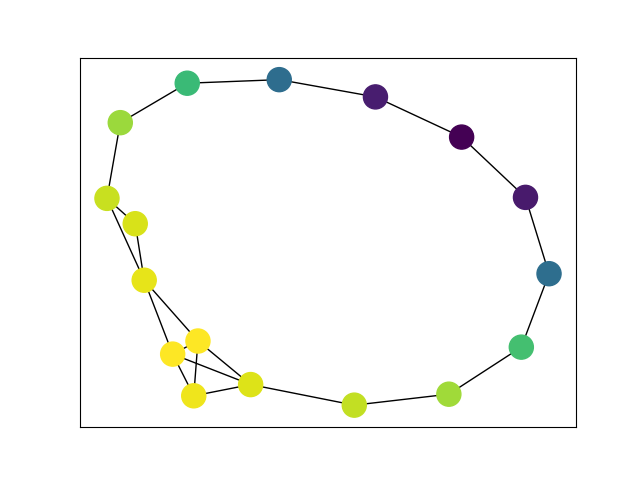

In [32]:
G = stm.mapper2networkx(mapper)
nx.draw_networkx(G, with_labels=False,
                 node_color=[mapper.node_info_[name]["colors"][0] for name in G.nodes()])

# Machine Learning

## Synthetic

In [33]:
np.random.seed(0)

Generate data.

In [34]:
X, y = make_blobs(n_samples=5000, n_features=2, random_state=42, cluster_std=5.0)
X_train, y_train = X[:3000], y[:3000]
X_valid, y_valid = X[3000:4000], y[3000:4000]
X_train_valid, y_train_valid = X[:4000], y[:4000]
X_test, y_test = X[4000:], y[4000:]

<IPython.core.display.Javascript object>


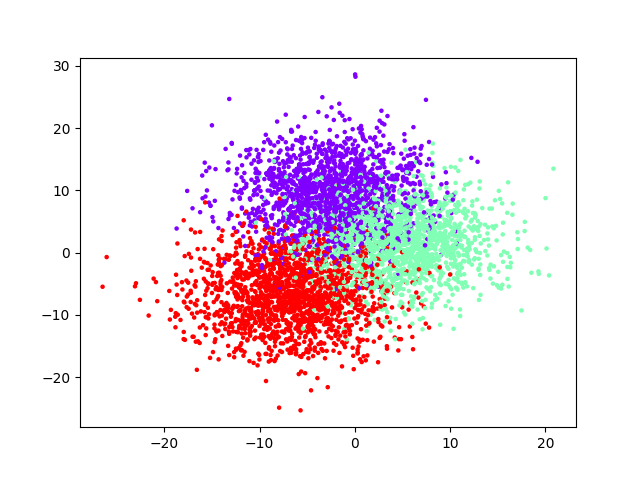

In [35]:
%matplotlib notebook
plt.figure()
plt.scatter(X[:,0], X[:,1], c=y, s=5, cmap="rainbow")
plt.show()

Train uncalibrated random forest classifier on whole train and validation data and evaluate on test data.

In [36]:
clf = RandomForestClassifier(n_estimators=25)
clf.fit(X_train_valid, y_train_valid)
clf_probs = clf.predict_proba(X_test)
score = log_loss(y_test, clf_probs)

Train random forest classifier, calibrate on validation data and evaluate on test data.

In [37]:
clf = RandomForestClassifier(n_estimators=25)
clf.fit(X_train, y_train)
clf_probs = clf.predict_proba(X_test)

In [38]:
mapper = sktda.MapperComplex(
    filters=clf_probs,
    filter_bnds=np.array([[np.nan, np.nan]]),
    resolutions=np.array([10,10,10]), gains=np.array([.3,.3,.3]), colors=clf_probs,
    clustering=AgglomerativeClustering(n_clusters=None, linkage="single", distance_threshold=10)
                            ).fit(X_test)

<IPython.core.display.Javascript object>


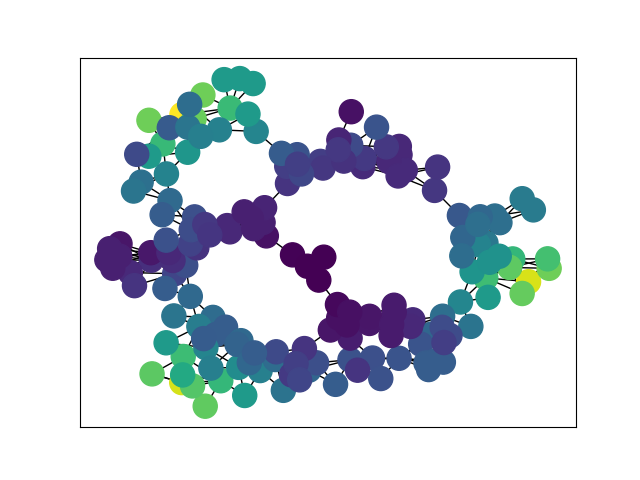

In [39]:
%matplotlib notebook
G = stm.mapper2networkx(mapper)
plt.figure()
nx.draw_networkx(G, with_labels=False, pos=nx.kamada_kawai_layout(G), 
                 node_color=[np.var(mapper.node_info_[name]["colors"]) for name in G.nodes()])

## Accelero

Data can be downloaded at https://archive.ics.uci.edu/ml/datasets/Human+Activity+Recognition+Using+Smartphones

In [40]:
file_path= "./uci/"

Features.

In [41]:
data_path = file_path + "train/X_train.txt"
activity_features = pd.read_csv(data_path, delim_whitespace=True, header=None)

Activities.

In [42]:
data_path = file_path + "train/y_train.txt"
activity  = pd.read_csv(data_path, delim_whitespace=True, header=None)
activity  = activity.values[:,0] - 1
activity_names = ['WALKING','WALKING_UPSTAIRS','WALKING_DOWNSTAIRS','SITTING','STANDING','LAYING']

Subjects.

In [43]:
data_path = file_path + "train/subject_train.txt"
sujet = pd.read_csv(data_path, delim_whitespace=True, header=None)
sujet = sujet.values[:,0]

In [44]:
features_nor = preprocessing.scale(activity_features)

Use naive Bayes for prediction.

In [45]:
gnb = GaussianNB()
gnb.fit(features_nor, activity)
pred = gnb.predict(features_nor)
scores = model_selection.cross_val_score(GaussianNB(), features_nor, activity, cv=10)
print(scores)

[0.70189702 0.66531165 0.67479675 0.55359566 0.83016304 0.64945652
 0.68894952 0.74590164 0.78005464 0.68579235]


Estimation of a posteriori probabilities.

In [46]:
posterior = gnb.predict_proba(features_nor)

In [47]:
delta = sktda.estimate_scale(features_nor, 100)

In [48]:
mapper = sktda.MapperComplex(
    filters=posterior,
    filter_bnds=np.array([[np.nan, np.nan]]),
    resolutions=3*np.ones([6]), gains=.4*np.ones([6]), colors=posterior,
    clustering=AgglomerativeClustering(n_clusters=None, linkage="single", distance_threshold=delta)
                            ).fit(features_nor)

<IPython.core.display.Javascript object>


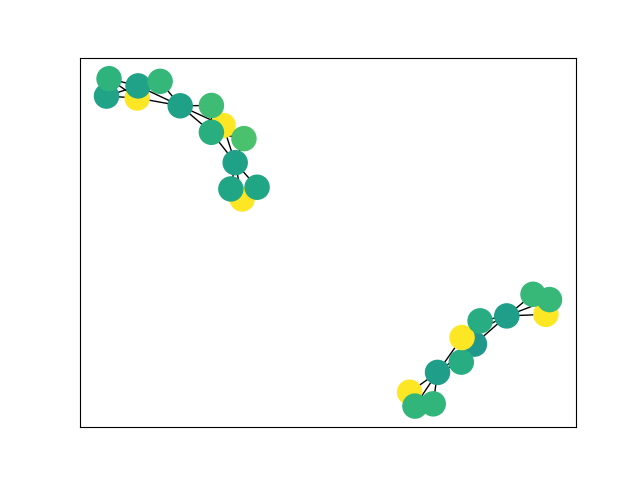

In [49]:
%matplotlib notebook
G = stm.mapper2networkx(mapper)
plt.figure()
nx.draw_networkx(G, with_labels=False,
                 node_color=[np.var(mapper.node_info_[name]["colors"]) for name in G.nodes()],
                 vmin=0., vmax=0.1)